# Stock Index Machine Learning Classification Model Comparisons

**Background:** Strategic investments in capital markets by accurately predicting positive or negative price movements will accelerate the ability to 'beat the market' and turn a higher profit by buying when prices will increase and selling before prices decrease. 

**Problem Statement:** Predicting price movements for individual stocks is extremely challenging, with seemingly random day-by-day fluctuations but a clear positive trend across major global markets. 

**Project Goal:** Compare multiple classification approaches to predict if the price of a composite index will increase or decrease on a day-by-day basis (i.e., at `T+1` where `T` is the current day). The intended outcome is to recommend a model to guide strategic investments, assuming a reliable model can be identified. The baseline model used is a *Random Baseline* to simulate a Random Walk approach for market prediction. 

Our focused index is *Euronext*, a European exchange based out of Amsterdam with a market capitalization of $10bn+ which trades in equities, ETFs, warrants, bonds, derivatives, commodities, FX, and indices.

**In-scope Models:** 
1. **Random Baseline Model**: random classification predictions to simulate a 'random walk' approach. Models more successful at classification will outperform random buy and sell decisions. 

2. **Logistic Regression**: tests if a stable, linear combination of predictive features provides a consistent probabilistic edge over the random baseline.

3. **K-Nearest Neighbors:**: a pattern-matching model to test the "history repeats" hypothesis by checking if today's market conditions mirror past "Up" or "Down" days.

4. **Decision Tree**: creates a human-readable flowchart of "if-then" rules to identify the most potent, simple trading signals in the data.

5. **XGBoost**: an advanced ensemble model to find complex, non-linear interactions between features that simpler models would miss.

**Dataset Terminology:**
- **Capital Markets**: A financial exchange for investors to buy and sell assets. 
- **Assets**: Financial instruments traded at capital markets, such as stocks, bonds, and commodities. 
- **Trade**: The activity of buying and selling an asset. 
- **Composite Index**: A grouping of assets to show how a sector or market performs over time (e.g., S&P 500 is a composite index of the leading 500 companies on US capital markets). 
- **Open**: The price of an index at time of market opening. 
- **Close**: The price of an index at the time of market closing. 
- **High**: The maximum price of an index throughout a trading day. 
- **Low**: The lowest price of an index throughout a trading day. 
- **Volume**: The amount of assets traded throughout a trading day. 
- **Adj. Close**: The price of an index at the time of market closing, account for corporate activity while maintaining capital capitalization. 

## 0. Operational

In [8]:
#Import relevant libraries for analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pathlib import Path
import sys

sys.path.append(str(Path('..').resolve())) 
from src.data_loader import load_data 
from src.feature_engineering import FeatureEngineering, DataPrep 
from src.train_test_split import TimeSeriesSplit
from src.models import LogisticTrainer, KNNTrainer, DecisionTreeTrainer, XGBTrainer 

In [44]:
# Load the file into a DataFrame
file_path = '../data/indexData.csv'
df = pd.read_csv(file_path)

## 1. EDA Visualizations
### 1.1. Missing and Zero Values Visualization

This step visualizes the number of missing and zero values in each column of the *Euronext* dataset. Approximately 2000 of 42,5000 (5%) values for every column are missing (except the unique identifiers `Index` and `Date`), and every `Volume` record is listed `0`.

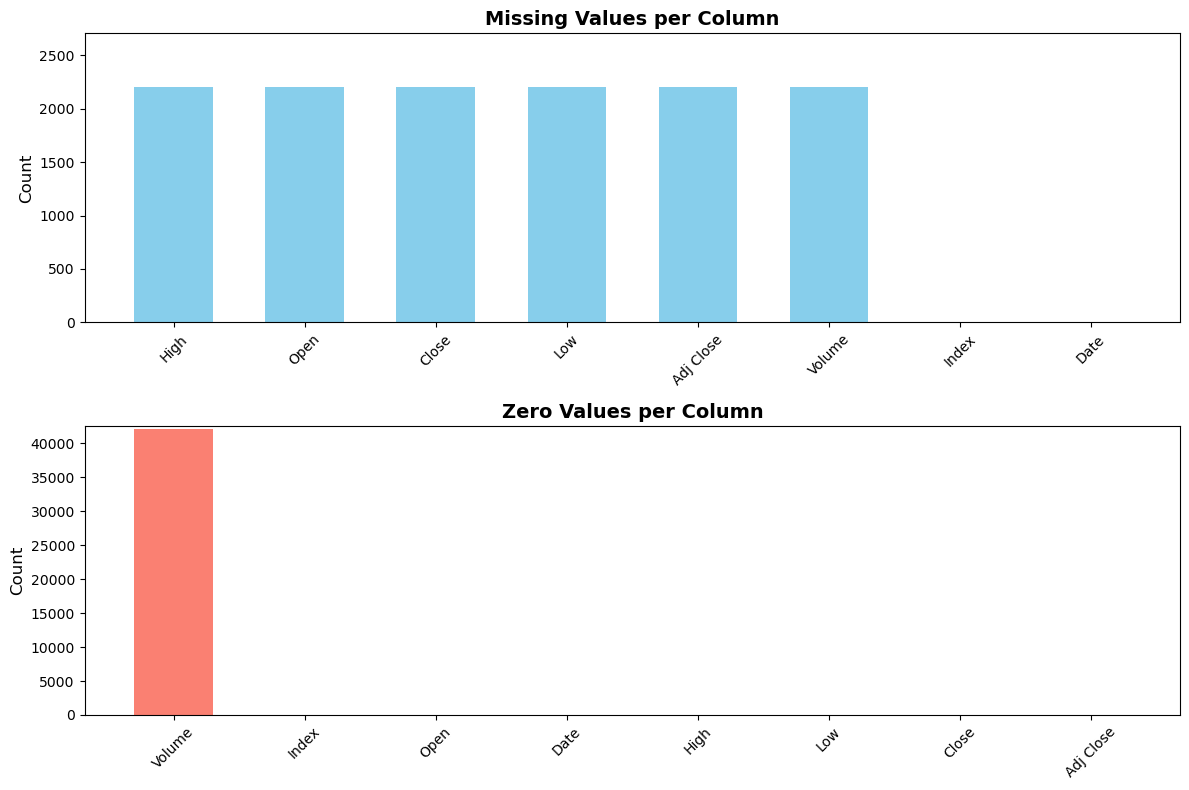

In [ ]:
# Create a 2-row figure
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # Adjusted figsize for better proportions
plt.subplots_adjust(hspace=0.4)

# Missing values (NaN)
missing_counts = df.isna().sum().sort_values(ascending=False)
axes[0].bar(missing_counts.index, missing_counts.values, color='skyblue', width=0.6)  # Bar width adjusted
axes[0].set_title('Missing Values per Column', fontsize=14, weight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Zero values
zero_counts = (df == 0).sum().sort_values(ascending=False)
axes[1].bar(zero_counts.index, zero_counts.values, color='salmon', width=0.6)  # Consistent bar width
axes[1].set_title('Zero Values per Column', fontsize=14, weight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Set a consistent y-axis limit if relevant
axes[0].set_ylim(0, missing_counts.max() + 500)  # Add some padding
axes[1].set_ylim(0, zero_counts.max() + 500) 

plt.tight_layout()
plt.show()

### 1.2. Distribution of Open, Close, High, and Low Values

This step visualizes the distribution for `Open`, `Close`, `High`, and `Low` values for all of the indices in the dataset. The distribution helps us understand how the data is spread across all the indices to pick a best-fit index, considering outliers or strange distributions in the data. 

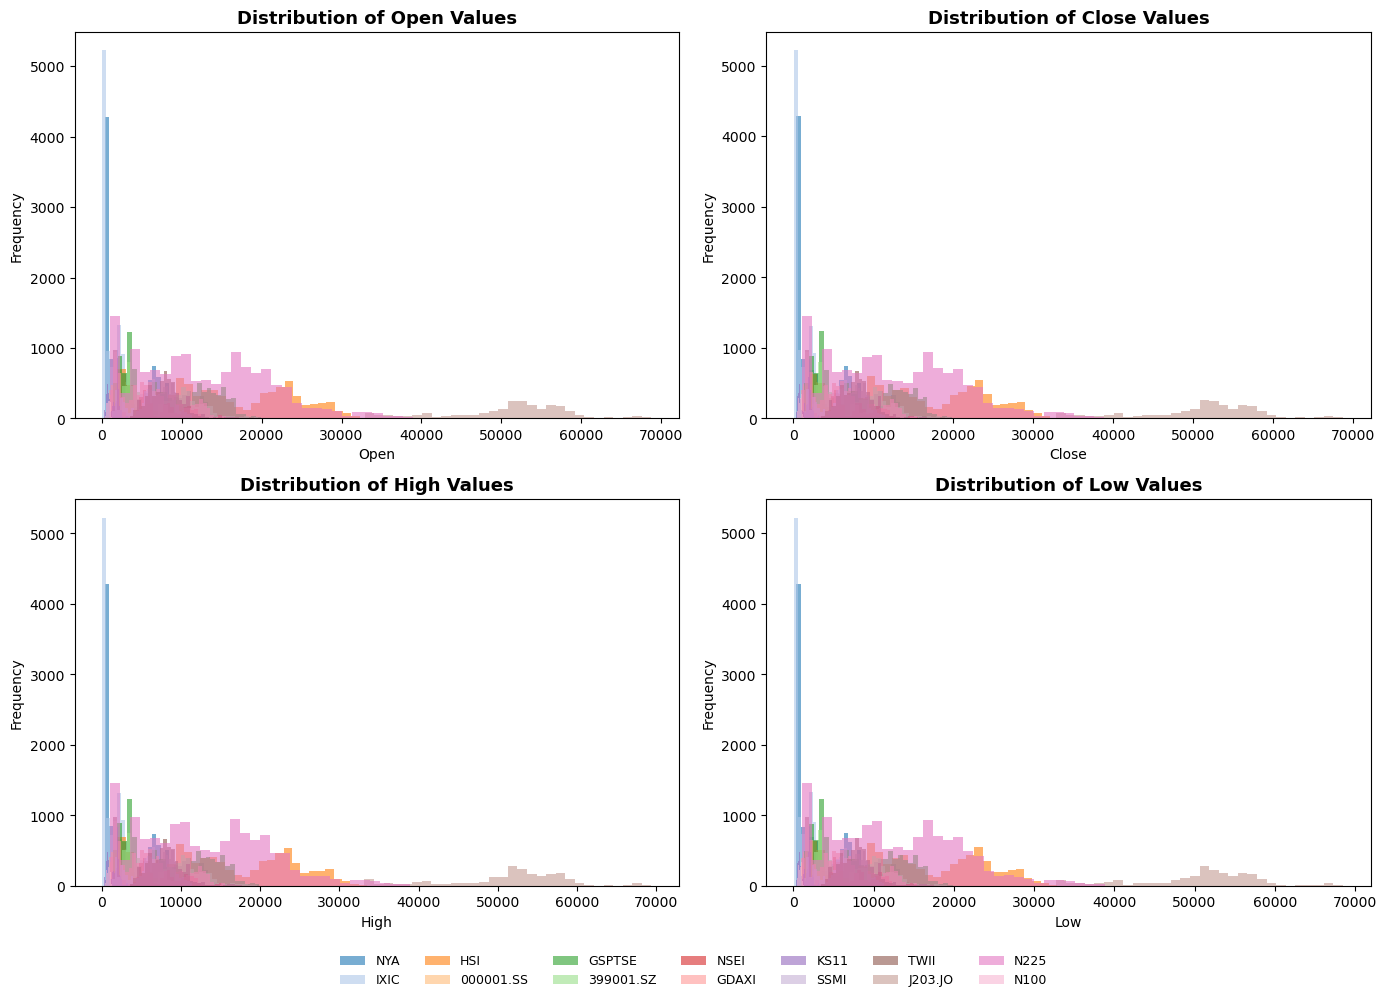

In [46]:
# Visualization Initialization
index_col = 'Index' 
unique_indices = df[index_col].unique()

# Generate a distinct color for each index (14 total)
colors = sns.color_palette("tab20", len(unique_indices))
color_map = dict(zip(unique_indices, colors))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
columns = ['Open', 'Close', 'High', 'Low']

for ax, col in zip(axes, columns):
    for idx in unique_indices:
        subset = df[df[index_col] == idx]
        ax.hist(subset[col].dropna(), bins=30, color=color_map[idx], alpha=0.6, label=idx)
    ax.set_title(f'Distribution of {col} Values', fontsize=13, weight='bold')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Frequency')

# Add a single legend below all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=7, frameon=False, fontsize=9)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # gap to fit legend
plt.show()


### 1.3. Distribution of Volume Values

This step visualizes the distribution of volume values across all the indices, where available. 

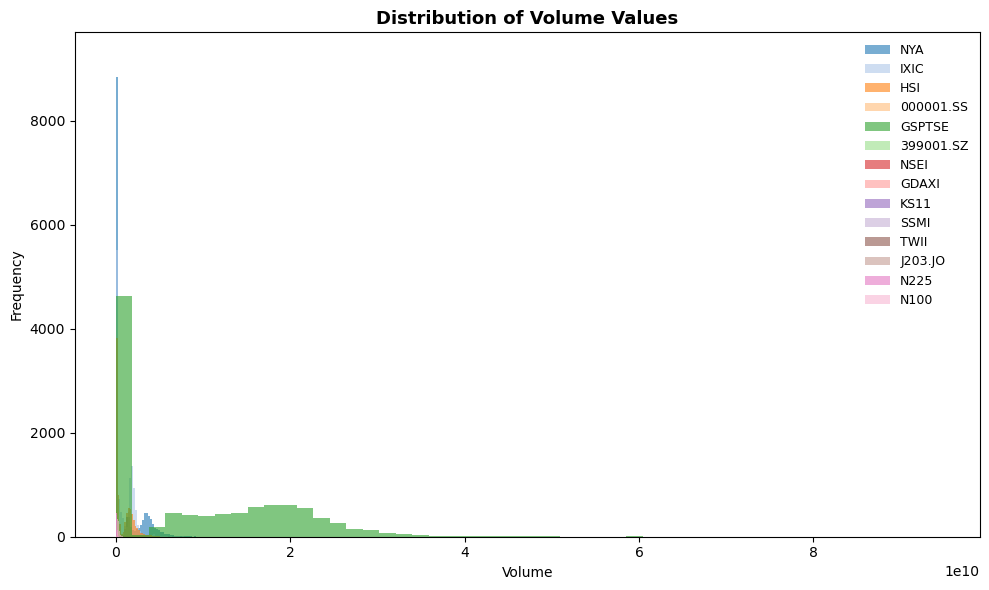

In [47]:
# Visualize Volume distribution separately
plt.figure(figsize=(10, 6))

# Plot Volume distribution for each index
for idx in unique_indices:
    subset = df[df[index_col] == idx]
    plt.hist(subset['Volume'].dropna(), bins=50, color=color_map[idx], alpha=0.6, label=idx)
plt.title('Distribution of Volume Values', fontsize=13, weight='bold')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend(loc='upper right', frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

In [48]:
# Summary for Zero Volume
zero_volume = df[df['Volume'] == 0]
print(f'Total records with zero Volume: {len(zero_volume)}','\n')

# Summary for Zero Volume per Index
zero_volume_per_index = zero_volume[index_col].value_counts()
print("Zero Volume per Index:")
print(zero_volume_per_index)


Total records with zero Volume: 42093 

Zero Volume per Index:
Index
N225         9239
NYA          8832
HSI          3602
IXIC         3457
SSMI         3039
GDAXI        2974
J203.JO      2346
N100         1657
399001.SZ    1570
000001.SS    1361
TWII         1353
GSPTSE       1343
NSEI         1320
Name: count, dtype: int64


# 2. Model Training & Evaluation

### 2.1 Initializing

The initialization step is used to import data from the `data_loader` module, creates model features, and splits time-series data in chronological order using the `train_test_split` module. 

These elements remain the same across all the models tested to ensure standardized testing and comparisons across models. 

In [2]:
# Prepare data using DataPrep component
prep = DataPrep(file_path='../data/indexData.csv')
df_eng, features = prep.prepare(stock_index_pattern='Euronext')

# Setup time-series split (reused across all trainers)
ts_split = TimeSeriesSplit(test_size=0.2)

Loading data from ../data/indexData.csv...
Found 3817 rows for Euronext
Selected 14 features: ['pct_change', 'sma_5', 'sma_20', 'ema_5', 'ema_20', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'lag_1', 'lag_2', 'lag_3', 'dow', 'month']
Dataset size: 3797, Classes: 2, Positive: 2022
Found 3817 rows for Euronext
Selected 14 features: ['pct_change', 'sma_5', 'sma_20', 'ema_5', 'ema_20', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'lag_1', 'lag_2', 'lag_3', 'dow', 'month']
Dataset size: 3797, Classes: 2, Positive: 2022


Numerical and categorical features have been selected to train the selected models. 

**Numerical Features:**
- pct_change: most recent daily return, capturing the direction and relative magnitude of change. 

- sma_t: t-day Simple Moving Average (SMA) that establishes the short- or medium-term price trend over t days. 

- ema_t: t-day Exponential Moving Average (EPA) that tracks the short- to medium-term trend, weighing recent prices more heavily. 

- rsi: momentum oscillator [0-100] that identifies potentially "overbought" (price may drop) or "oversold" (price may increase) conditions.

- macd (Moving Average Convergence Divergence): core "macd line" used to identify price trend direction and momentum.

- macd_signal: 9-day ema of the macd line, indicating "buy" or "sell" signals when crossed.

- macd_hist: macd histogram (macd - macd\_signal) that measures the accelerating or decelerating momentum of price trends.

- lag_t: The percentage change from t days prior, testing for immediate auto-correlation. 

**Categorical Features:**

- dow: day of the week (0-6), used to capture weekly seasonal patterns like the "monday effect" or "friday run-up".

- month: month of the year (1-12), used to capture annual seasonal patterns. 

In [3]:
# Define numerical and categorical features for Decision Tree
numeric_features = [
    'pct_change','sma_5','sma_20','ema_5','ema_20','rsi',
    'macd','macd_signal','macd_hist','lag_1','lag_2','lag_3'
]
categorical_features = ['dow', 'month']

available_numeric = [f for f in numeric_features if f in df_eng.columns]
available_categorical = [f for f in categorical_features if f in df_eng.columns]

dt_features = available_numeric + available_categorical

print(f"Numerical Features: {available_numeric}\n")
print(f"Categorical Features: {available_categorical}\n")

Numerical Features: ['pct_change', 'sma_5', 'sma_20', 'ema_5', 'ema_20', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'lag_1', 'lag_2', 'lag_3']

Categorical Features: ['dow', 'month']



### 2.2. Logisitic Regression

In [4]:
# Train LogisticRegression model using the trainer component
trainer_lr = LogisticTrainer(features=features, numeric_features=numeric_features, categorical_features=categorical_features, solver='liblinear')
X_train, X_test, y_train, y_test = trainer_lr.prepare_data(df_eng, ts_split)
trainer_lr.fit(X_train, y_train)

In [5]:
# Evaluate model
y_pred_lr = trainer_lr.predict(X_test)
metrics = trainer_lr.evaluate(X_test, y_test)
print(f'Accuracy: {metrics["accuracy"]:.4f}')
print('Classification report:\n', metrics['classification_report'])
print('Confusion matrix:\n', metrics['confusion_matrix'])
if metrics['roc_auc'] is not None:
    print(f'ROC AUC: {metrics["roc_auc"]:.4f}')

# Save model
trainer_lr.save(str(Path('..') / 'models' / 'logistic_model_euronext.pkl'))
print(f'Model saved to models/logistic_model_euronext.pkl')


Accuracy: 0.5368
Classification report:
               precision    recall  f1-score   support

           0     0.4703    0.2794    0.3506       340
           1     0.5609    0.7452    0.6401       420

    accuracy                         0.5368       760
   macro avg     0.5156    0.5123    0.4953       760
weighted avg     0.5204    0.5368    0.5106       760

Confusion matrix:
 [[ 95 245]
 [107 313]]
ROC AUC: 0.5226
Model saved to models/logistic_model_euronext.pkl


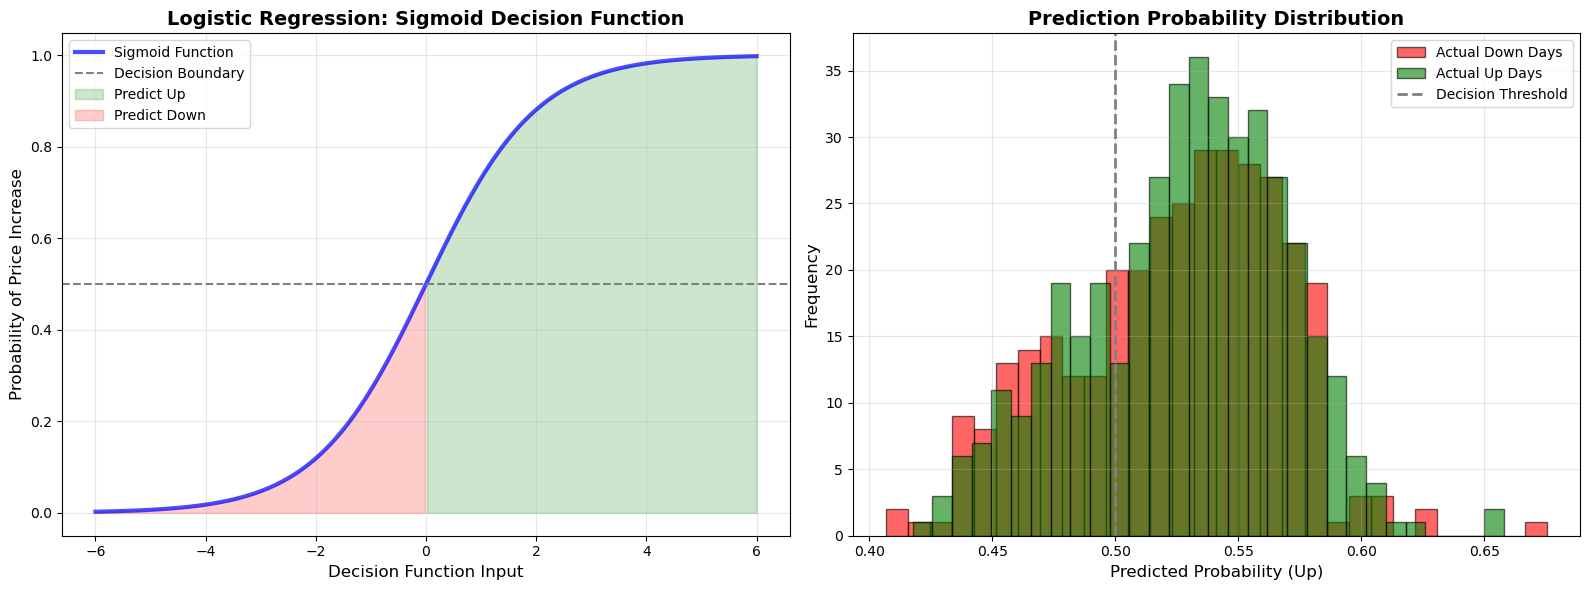

In [10]:
# Logistic Regression: Sigmoid Probability Curve Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Sigmoid curve with prediction probabilities
y_proba_lr = trainer_lr.pipeline.predict_proba(X_test)[:, 1]
sorted_idx = np.argsort(y_proba_lr)
sorted_proba = y_proba_lr[sorted_idx]

# Create smooth sigmoid curve
x_sigmoid = np.linspace(-6, 6, 300)
y_sigmoid = 1 / (1 + np.exp(-x_sigmoid))

axes[0].plot(x_sigmoid, y_sigmoid, 'b-', linewidth=3, label='Sigmoid Function', alpha=0.7)
axes[0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, label='Decision Boundary')
axes[0].fill_between(x_sigmoid, 0, y_sigmoid, where=(y_sigmoid >= 0.5), alpha=0.2, color='green', label='Predict Up')
axes[0].fill_between(x_sigmoid, 0, y_sigmoid, where=(y_sigmoid < 0.5), alpha=0.2, color='red', label='Predict Down')
axes[0].set_title('Logistic Regression: Sigmoid Decision Function', fontsize=14, weight='bold')
axes[0].set_xlabel('Decision Function Input', fontsize=12)
axes[0].set_ylabel('Probability of Price Increase', fontsize=12)
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(alpha=0.3)

# Right plot: Prediction probability distribution
axes[1].hist(y_proba_lr[y_test == 0], bins=30, alpha=0.6, color='red', label='Actual Down Days', edgecolor='black')
axes[1].hist(y_proba_lr[y_test == 1], bins=30, alpha=0.6, color='green', label='Actual Up Days', edgecolor='black')
axes[1].axvline(x=0.5, color='gray', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1].set_title('Prediction Probability Distribution', fontsize=14, weight='bold')
axes[1].set_xlabel('Predicted Probability (Up)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 2.3. KNN

In [12]:
# KNN model using the trainer component
trainer_knn = KNNTrainer(features=features, numeric_features=numeric_features, categorical_features=categorical_features, n_neighbors=5)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = trainer_knn.prepare_data(df_eng, ts_split)
trainer_knn.fit(X_train_knn, y_train_knn)

In [13]:
# Evaluate KNN model
y_pred_knn = trainer_knn.predict(X_test_knn)
metrics_knn = trainer_knn.evaluate(X_test_knn, y_test_knn)
print('Accuracy:', round(metrics_knn['accuracy'], 4))
print('Classification report:\n', metrics_knn['classification_report'])
print('Confusion matrix:\n', metrics_knn['confusion_matrix'])

# Save model
trainer_knn.save(str(Path('..') / 'models' / 'knn_model_euronext.pkl'))
print(f'Model saved to models/knn_model_euronext.pkl')


Accuracy: 0.4816
Classification report:
               precision    recall  f1-score   support

           0     0.4297    0.4853    0.4558       340
           1     0.5346    0.4786    0.5050       420

    accuracy                         0.4816       760
   macro avg     0.4821    0.4819    0.4804       760
weighted avg     0.4877    0.4816    0.4830       760

Confusion matrix:
 [[165 175]
 [219 201]]
Model saved to models/knn_model_euronext.pkl


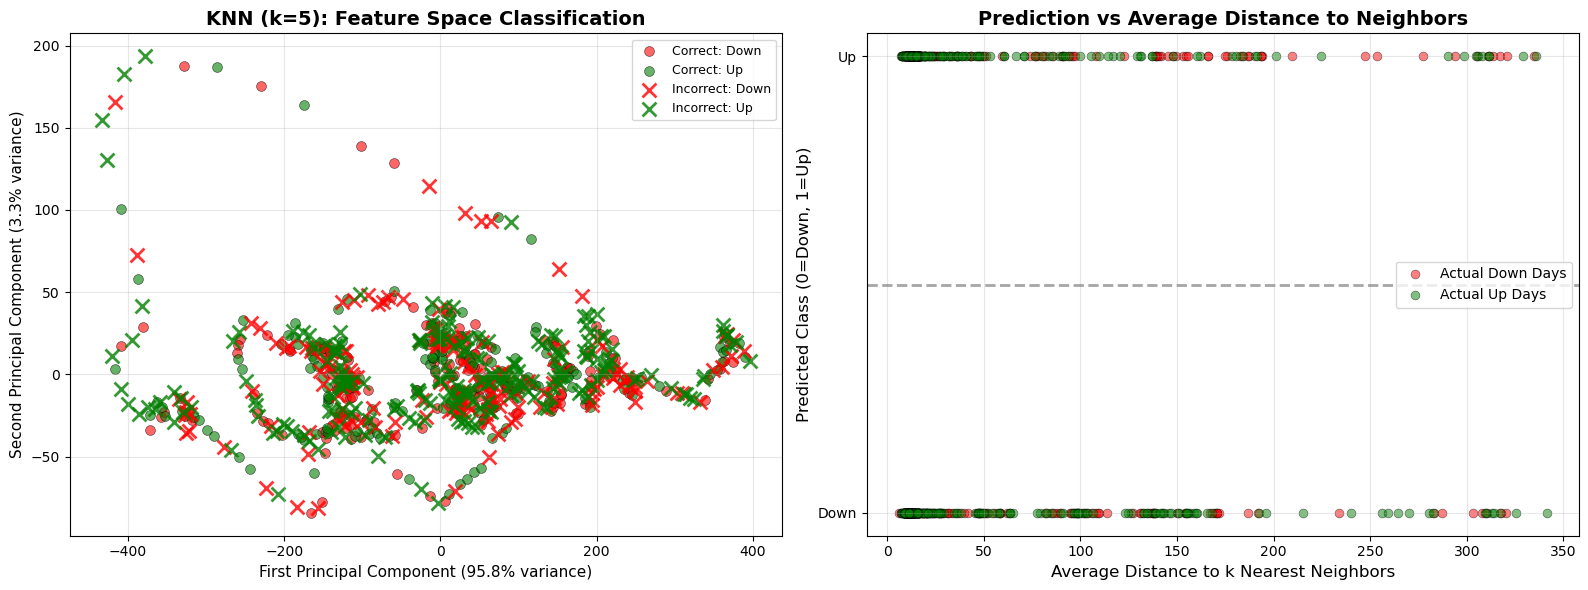

In [18]:
# KNN: Feature Space Visualization with Decision Regions
from sklearn.decomposition import PCA

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Use PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_knn)

# Left plot: Scatter plot of predictions vs actual in PCA space
correct_mask = (y_pred_knn == y_test_knn)
incorrect_mask = ~correct_mask

# Plot correct predictions
axes[0].scatter(X_test_pca[correct_mask & (y_test_knn == 0), 0], 
                X_test_pca[correct_mask & (y_test_knn == 0), 1],
                c='red', marker='o', s=50, alpha=0.6, label='Correct: Down', edgecolors='black', linewidths=0.5)
axes[0].scatter(X_test_pca[correct_mask & (y_test_knn == 1), 0], 
                X_test_pca[correct_mask & (y_test_knn == 1), 1],
                c='green', marker='o', s=50, alpha=0.6, label='Correct: Up', edgecolors='black', linewidths=0.5)

# Plot incorrect predictions with X markers
axes[0].scatter(X_test_pca[incorrect_mask & (y_test_knn == 0), 0], 
                X_test_pca[incorrect_mask & (y_test_knn == 0), 1],
                c='red', marker='x', s=100, alpha=0.8, label='Incorrect: Down', linewidths=2)
axes[0].scatter(X_test_pca[incorrect_mask & (y_test_knn == 1), 0], 
                X_test_pca[incorrect_mask & (y_test_knn == 1), 1],
                c='green', marker='x', s=100, alpha=0.8, label='Incorrect: Up', linewidths=2)

axes[0].set_title(f'KNN (k={trainer_knn.n_neighbors}): Feature Space Classification', fontsize=14, weight='bold')
axes[0].set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(alpha=0.3)

# Right plot: Distance to nearest neighbors analysis
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=trainer_knn.n_neighbors)
nn.fit(X_train_knn)
distances, indices = nn.kneighbors(X_test_knn)
avg_distances = distances.mean(axis=1)

axes[1].scatter(avg_distances[y_test_knn == 0], y_pred_knn[y_test_knn == 0], 
                c='red', alpha=0.5, s=40, label='Actual Down Days', edgecolors='black', linewidths=0.5)
axes[1].scatter(avg_distances[y_test_knn == 1], y_pred_knn[y_test_knn == 1], 
                c='green', alpha=0.5, s=40, label='Actual Up Days', edgecolors='black', linewidths=0.5)
axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=2, alpha=0.7)
axes[1].set_title('Prediction vs Average Distance to Neighbors', fontsize=14, weight='bold')
axes[1].set_xlabel('Average Distance to k Nearest Neighbors', fontsize=12)
axes[1].set_ylabel('Predicted Class (0=Down, 1=Up)', fontsize=12)
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Down', 'Up'])
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 2.4. Decision Tree

In [19]:
# Decision Tree model using the trainer component
trainer_dt = DecisionTreeTrainer(
    features=dt_features,
    numeric_features=available_numeric,
    categorical_features=available_categorical,
    max_depth=10
)
X_train_dt, X_test_dt, y_train_dt, y_test_dt = trainer_dt.prepare_data(df_eng, ts_split)
trainer_dt.fit(X_train_dt, y_train_dt)

In [20]:
# Evaluate Decision Tree model
y_pred_dt = trainer_dt.predict(X_test_dt)
metrics_dt = trainer_dt.evaluate(X_test_dt, y_test_dt)
print('Accuracy:', round(metrics_dt['accuracy'], 4))
print('Classification report:\n', metrics_dt['classification_report'])
print('Confusion matrix:\n', metrics_dt['confusion_matrix'])

# Save model
trainer_dt.save(str(Path('..') / 'models' / 'decision_tree_model_euronext.pkl'))
print(f'Model saved to models/decision_tree_model_euronext.pkl')


Accuracy: 0.4618
Classification report:
               precision    recall  f1-score   support

           0     0.4203    0.5353    0.4709       340
           1     0.5168    0.4024    0.4525       420

    accuracy                         0.4618       760
   macro avg     0.4686    0.4688    0.4617       760
weighted avg     0.4737    0.4618    0.4607       760

Confusion matrix:
 [[182 158]
 [251 169]]
Model saved to models/decision_tree_model_euronext.pkl


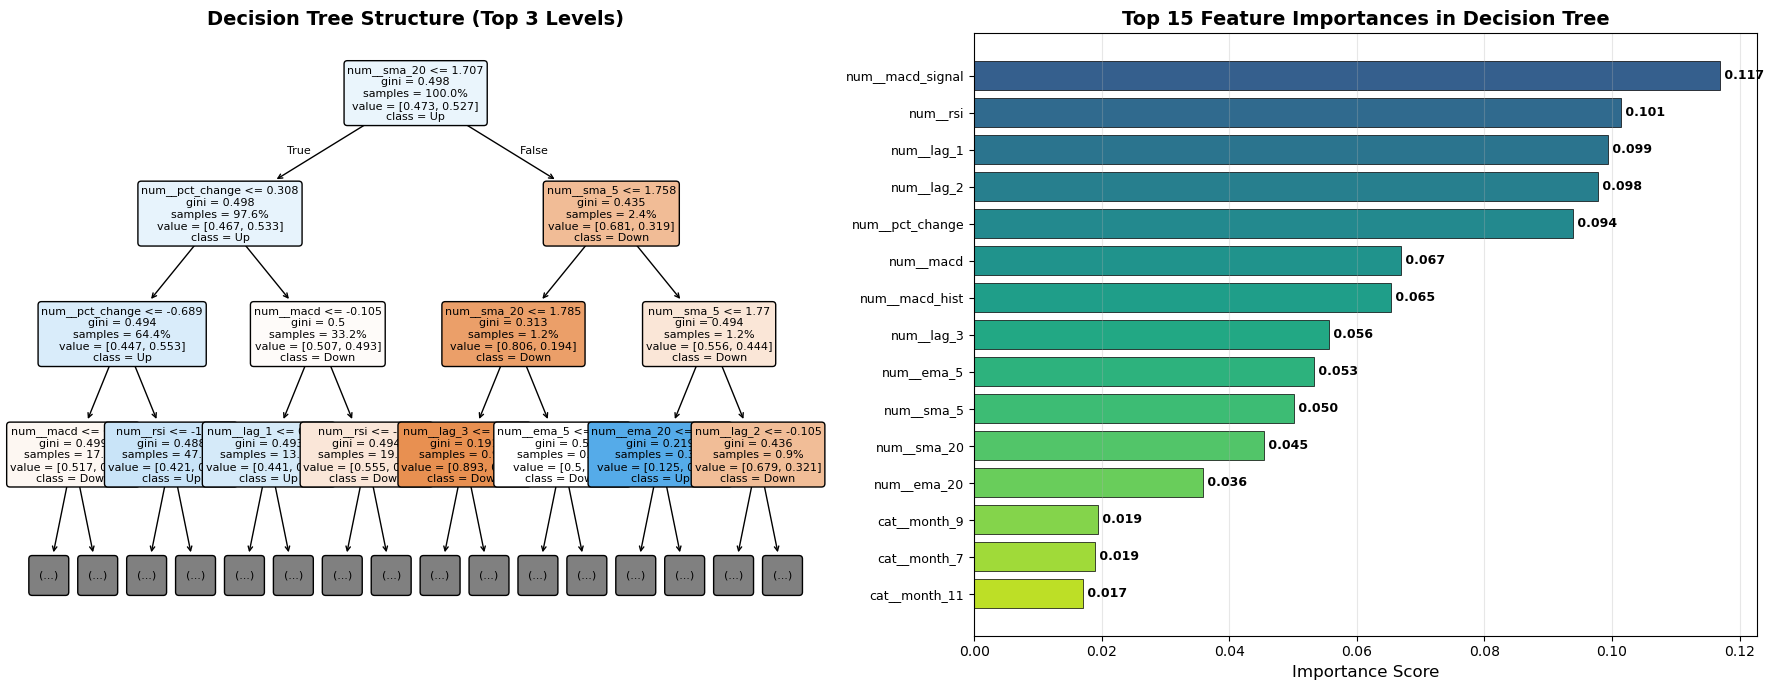

Decision Tree Statistics:
  Tree depth: 10
  Number of leaves: 171
  Total features after preprocessing: 27


In [23]:
# Decision Tree: Structure and Feature Importance Visualization
from sklearn.tree import plot_tree

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Get the actual decision tree model from the pipeline
dt_model = trainer_dt.pipeline.named_steps['clf']

# Get the feature names after preprocessing
preprocessor = trainer_dt.pipeline.named_steps['preprocessor']
try:
    # Get feature names after transformation
    transformed_feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback: construct feature names manually
    transformed_feature_names = available_numeric.copy()
    if available_categorical:
        # OneHotEncoder creates features like "cat__feature_value"
        enc = preprocessor.named_transformers_['cat']
        cat_features = enc.get_feature_names_out(available_categorical)
        transformed_feature_names.extend(cat_features)

# Left plot: Simplified tree structure (top 3 levels only for readability)
plot_tree(dt_model, 
          max_depth=3,
          feature_names=transformed_feature_names,
          class_names=['Down', 'Up'],
          filled=True,
          rounded=True,
          fontsize=8,
          ax=axes[0],
          proportion=True)
axes[0].set_title('Decision Tree Structure (Top 3 Levels)', fontsize=14, weight='bold')

# Right plot: Feature importance
feature_importance = dt_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

# Only show top 15 features for readability
top_n = min(15, len(sorted_idx))
top_idx = sorted_idx[:top_n]

# Create horizontal bar chart with gradient colors
colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
bars = axes[1].barh(range(top_n), feature_importance[top_idx], color=colors, edgecolor='black', linewidth=0.5)

axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([transformed_feature_names[i] for i in top_idx], fontsize=9)
axes[1].invert_yaxis()
axes[1].set_title('Top 15 Feature Importances in Decision Tree', fontsize=14, weight='bold')
axes[1].set_xlabel('Importance Score', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, importance) in enumerate(zip(bars, feature_importance[top_idx])):
    if importance > 0.01:  # Only label significant features
        axes[1].text(importance, i, f' {importance:.3f}', 
                    va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print tree statistics
print(f"Decision Tree Statistics:")
print(f"  Tree depth: {dt_model.get_depth()}")
print(f"  Number of leaves: {dt_model.get_n_leaves()}")
print(f"  Total features after preprocessing: {len(transformed_feature_names)}")

### 2.5. XGBoost

In [24]:
# XGBoost model using the trainer component
trainer_xgb = XGBTrainer(features=features, numeric_features=numeric_features, categorical_features=categorical_features, n_estimators=100, max_depth=6, learning_rate=0.1)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = trainer_xgb.prepare_data(df_eng, ts_split)
trainer_xgb.fit(X_train_xgb, y_train_xgb)

In [25]:
# Evaluate XGBoost model
y_pred_xgb = trainer_xgb.predict(X_test_xgb)
metrics_xgb = trainer_xgb.evaluate(X_test_xgb, y_test_xgb)
print('Accuracy:', round(metrics_xgb['accuracy'], 4))
print('Classification report:\n', metrics_xgb['classification_report'])
print('Confusion matrix:\n', metrics_xgb['confusion_matrix'])
if metrics_xgb['roc_auc'] is not None:
    print(f'ROC AUC: {metrics_xgb["roc_auc"]:.4f}')

# Save model
trainer_xgb.save(str(Path('..') / 'models' / 'xgb_model_euronext.pkl'))
print(f'Model saved to models/xgb_model_euronext.pkl')


Accuracy: 0.5
Classification report:
               precision    recall  f1-score   support

           0     0.4606    0.6882    0.5519       340
           1     0.5794    0.3476    0.4345       420

    accuracy                         0.5000       760
   macro avg     0.5200    0.5179    0.4932       760
weighted avg     0.5262    0.5000    0.4870       760

Confusion matrix:
 [[234 106]
 [274 146]]
ROC AUC: 0.5206
Model saved to models/xgb_model_euronext.pkl


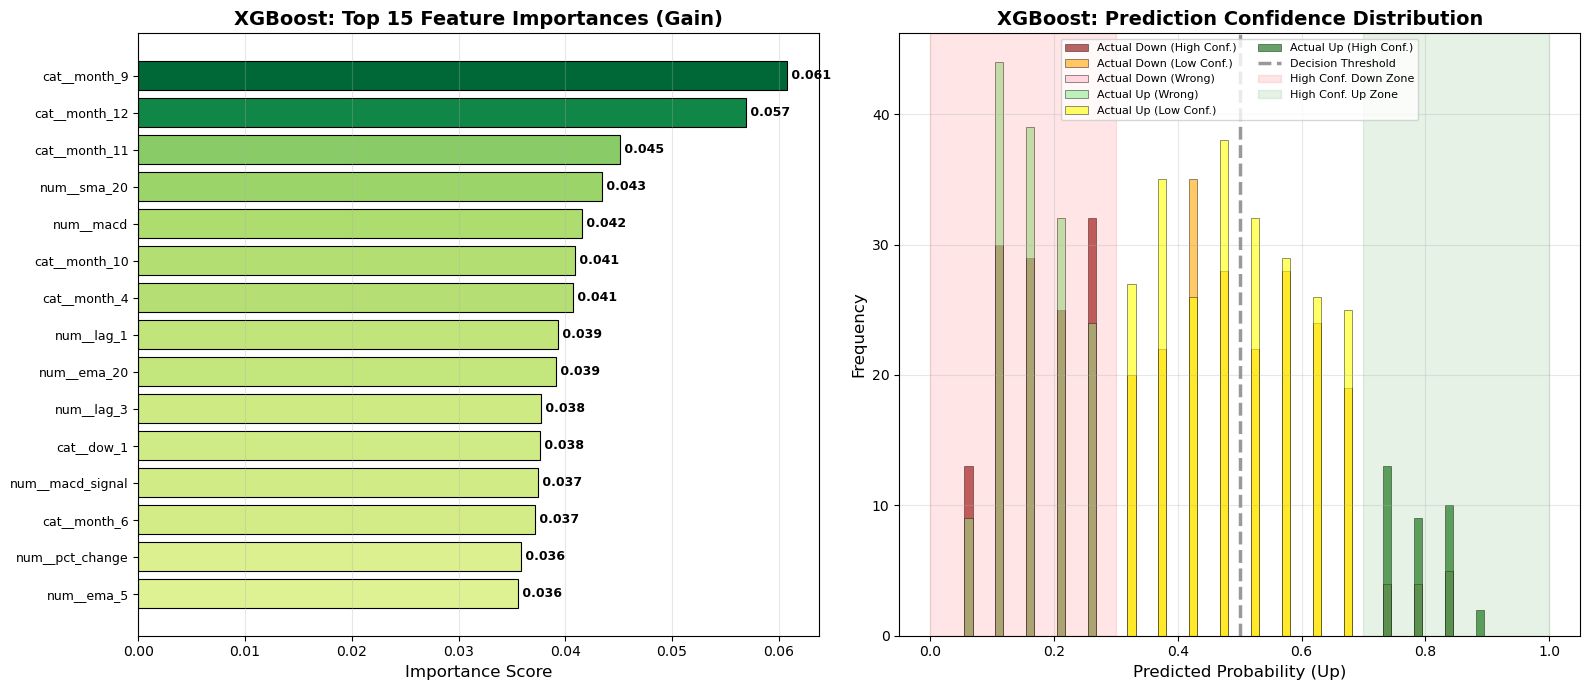

XGBoost Confidence Analysis:
  High confidence UP predictions (≥70%): 47 (6.2%)
  High confidence DOWN predictions (≤30%): 277 (36.4%)
  Uncertain predictions (30-70%): 436 (57.4%)


In [29]:
# XGBoost: Feature Importance and Prediction Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Get the actual XGBoost model from the pipeline
xgb_model = trainer_xgb.pipeline.named_steps['clf']

# Get the feature names after preprocessing
preprocessor_xgb = trainer_xgb.pipeline.named_steps['preprocessor']
try:
    # Get feature names after transformation
    transformed_feature_names_xgb = preprocessor_xgb.get_feature_names_out()
except AttributeError:
    # Fallback: construct feature names manually
    transformed_feature_names_xgb = numeric_features.copy()
    if categorical_features:
        enc = preprocessor_xgb.named_transformers_['cat']
        cat_features = enc.get_feature_names_out(categorical_features)
        transformed_feature_names_xgb.extend(cat_features)

# Left plot: Feature importance with gradient colors (waterfall style)
feature_importance_xgb = xgb_model.feature_importances_
sorted_idx_xgb = np.argsort(feature_importance_xgb)[::-1]

# Only show top 15 features for readability
top_n_xgb = min(15, len(sorted_idx_xgb))
top_idx_xgb = sorted_idx_xgb[:top_n_xgb]

# Create color gradient from red (low) to green (high)
norm_importance = feature_importance_xgb[top_idx_xgb] / feature_importance_xgb[top_idx_xgb].max()
colors_gradient = plt.cm.RdYlGn(norm_importance)

bars = axes[0].barh(range(top_n_xgb), feature_importance_xgb[top_idx_xgb], 
                     color=colors_gradient, edgecolor='black', linewidth=0.8)

axes[0].set_yticks(range(top_n_xgb))
axes[0].set_yticklabels([transformed_feature_names_xgb[i] for i in top_idx_xgb], fontsize=9)
axes[0].invert_yaxis()
axes[0].set_title('XGBoost: Top 15 Feature Importances (Gain)', fontsize=14, weight='bold')
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, feature_importance_xgb[top_idx_xgb])):
    if importance > 0.01:
        axes[0].text(importance, i, f' {importance:.3f}', 
                    va='center', fontsize=9, fontweight='bold')

# Right plot: Prediction probability distribution with confidence zones
y_proba_xgb = trainer_xgb.pipeline.predict_proba(X_test_xgb)[:, 1]

# Create stacked histogram showing confidence zones
bins = np.linspace(0, 1, 21)
axes[1].hist([y_proba_xgb[(y_test_xgb == 0) & (y_proba_xgb < 0.3)],
              y_proba_xgb[(y_test_xgb == 0) & (y_proba_xgb >= 0.3) & (y_proba_xgb < 0.7)],
              y_proba_xgb[(y_test_xgb == 0) & (y_proba_xgb >= 0.7)]], 
         bins=bins, stacked=False, alpha=0.6, 
         color=['darkred', 'orange', 'pink'], 
         label=['Actual Down (High Conf.)', 'Actual Down (Low Conf.)', 'Actual Down (Wrong)'],
         edgecolor='black', linewidth=0.5)

axes[1].hist([y_proba_xgb[(y_test_xgb == 1) & (y_proba_xgb < 0.3)],
              y_proba_xgb[(y_test_xgb == 1) & (y_proba_xgb >= 0.3) & (y_proba_xgb < 0.7)],
              y_proba_xgb[(y_test_xgb == 1) & (y_proba_xgb >= 0.7)]], 
         bins=bins, stacked=False, alpha=0.6, 
         color=['lightgreen', 'yellow', 'darkgreen'], 
         label=['Actual Up (Wrong)', 'Actual Up (Low Conf.)', 'Actual Up (High Conf.)'],
         edgecolor='black', linewidth=0.5)

axes[1].axvline(x=0.5, color='gray', linestyle='--', linewidth=2.5, label='Decision Threshold', alpha=0.8)
axes[1].axvspan(0, 0.3, alpha=0.1, color='red', label='High Conf. Down Zone')
axes[1].axvspan(0.7, 1, alpha=0.1, color='green', label='High Conf. Up Zone')
axes[1].set_title('XGBoost: Prediction Confidence Distribution', fontsize=14, weight='bold')
axes[1].set_xlabel('Predicted Probability (Up)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend(loc='upper center', fontsize=8, ncol=2)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
high_conf_up = (y_proba_xgb >= 0.7).sum()
high_conf_down = (y_proba_xgb <= 0.3).sum()
uncertain = ((y_proba_xgb > 0.3) & (y_proba_xgb < 0.7)).sum()

print(f"XGBoost Confidence Analysis:")
print(f"  High confidence UP predictions (≥70%): {high_conf_up} ({high_conf_up/len(y_proba_xgb)*100:.1f}%)")
print(f"  High confidence DOWN predictions (≤30%): {high_conf_down} ({high_conf_down/len(y_proba_xgb)*100:.1f}%)")
print(f"  Uncertain predictions (30-70%): {uncertain} ({uncertain/len(y_proba_xgb)*100:.1f}%)")

## 3. Results and Discussion vs Random Baseline Model

This section generates the **Random Baseline Model** (i.e., randomly generated classifiers for price increases and decreases) to compare the other models. 

Multiple metrics are available to compare the models. The primary metric used here is ROC AUC, "Receiver Operating Characteristic Area Under the Curve". 

**Available Metrics:** 
- **Accuracy** `[0-1]`: the percentage of correctly-classified days, *overall* (e.g., the model is right 50% of the time).

- **Precision** `[0-1]`: the percentage of correct classification when the model predicts the target class (e.g., when predicting a price increase [`1`], the model is right 55% of the time).

- **Recall** `[0-1]`: the percentage of correctly-classified instances for the target class (e.g., of 100 days of price increases, the model predicted 60% of those days). 

- **f1-score** `[0-1]`: a single-value attempting to balance the *accuracy* and *precision* for a model (e.g., a higher f-score indicates a better 'balance' of *accuracy* and *precision*)

- **ROC AUC**`[0-1]`: a single-value attempting to measure how well a model can separate / differentiate price increase and price decrease days due to effective classification behaviour vs random guessing; the metric incorporates model outputs (`0.3`, `0.5`, `0.6`, `0.9`, etc.) and not the final classification (`[0||1]`) understand the quality of the model performance. E.g., ROC AUC = `1.0` means the model is a perfect classifier; `0.5` = random guessing; `0.0` = the model, impressively, performs worse than random guessing. 

ROC AUC is exceptionally good at helping compare the performance of models, and so it is used in conjunction with each model's Confusion Matrix for assessment. 

Each metric is compared against the **Random Baseline Model** and a delta ROC AUC is used to identify the best performing model. 

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Generate random predictions 
np.random.seed(42)
y_random = np.random.randint(0, 2, size=len(y_test))

# Calculate metrics for random classifier
random_metrics = {
    'Accuracy': accuracy_score(y_test, y_random),
    'Precision': precision_score(y_test, y_random),
    'Recall': recall_score(y_test, y_random),
    'F1-Score': f1_score(y_test, y_random),
    'ROC AUC': roc_auc_score(y_test, y_random) if len(np.unique(y_random)) > 1 else None
}

# Collect all model metrics for comparison 
comparison_data = {
    'Random': random_metrics,
    'Logistic Regression': {
        'Accuracy': metrics['accuracy'],
        'Precision': precision_score(y_test, y_pred_lr),
        'Recall': recall_score(y_test, y_pred_lr),
        'F1-Score': f1_score(y_test, y_pred_lr),
        'ROC AUC': metrics['roc_auc']
    },
    'KNN': {
        'Accuracy': metrics_knn['accuracy'],
        'Precision': precision_score(y_test_knn, y_pred_knn),
        'Recall': recall_score(y_test_knn, y_pred_knn),
        'F1-Score': f1_score(y_test_knn, y_pred_knn),
        'ROC AUC': metrics_knn['roc_auc']
    },
    'Decision Tree': {
        'Accuracy': metrics_dt['accuracy'],
        'Precision': precision_score(y_test_dt, y_pred_dt),
        'Recall': recall_score(y_test_dt, y_pred_dt),
        'F1-Score': f1_score(y_test_dt, y_pred_dt),
        'ROC AUC': metrics_dt['roc_auc']
    },
    'XGBoost': {
        'Accuracy': metrics_xgb['accuracy'],
        'Precision': precision_score(y_test_xgb, y_pred_xgb),
        'Recall': recall_score(y_test_xgb, y_pred_xgb),
        'F1-Score': f1_score(y_test_xgb, y_pred_xgb),
        'ROC AUC': metrics_xgb['roc_auc']
    }
}

# Display comparison as DataFrame
comparison_df = pd.DataFrame(comparison_data).T
print("Model Performance Comparison vs Random Baseline")
print("=" * 70)
print(comparison_df.round(4))
print("\n")

# Calculate improvement over random classifier
print("Improvement Over Random Classifier (ROC AUC %)")
print("=" * 70)
for model in ['Logistic Regression', 'KNN', 'Decision Tree', 'XGBoost']:
    improvement = (comparison_data[model]['ROC AUC'] - comparison_data['Random']['ROC AUC']) * 100
    print(f"{model:20s}: {improvement:+.2f}%")


Model Performance Comparison vs Random Baseline
                     Accuracy  Precision  Recall  F1-Score  ROC AUC
Random                 0.5224     0.5718  0.5405    0.5557   0.5202
Logistic Regression    0.5368     0.5609  0.7452    0.6401   0.5226
KNN                    0.4816     0.5346  0.4786    0.5050   0.4918
Decision Tree          0.4618     0.5168  0.4024    0.4525   0.4712
XGBoost                0.5000     0.5794  0.3476    0.4345   0.5206


Improvement Over Random Classifier (ROC AUC %)
Logistic Regression : +0.24%
KNN                 : -2.85%
Decision Tree       : -4.91%
XGBoost             : +0.03%


#### Results: 

**Random Baseline Model**: a random walk approach was correct `52.24%` of the time. The recall of `0.5405` indicates the model correctly classified `54%` of days where index prices rose over time, and a ROC AUC of `0.5202` indicates index prices have a propensity to increase over time and are not truly random. The data is biased towards increasing, `1`, and randomly guessing shows positive performance over time. 

**Logistic Regression**: a linear probabilistic approach was correct `53.68%` of the time. The recall of `0.7452` indicates the model correctly classified over `74%` of days where index prices rose, and a ROC AUC of `0.5226` indicates its ability to discriminate between "Up" and "Down" days was marginally (`+0.24%`) better than the random baseline. This model is strongly biased towards predicting "Up," catching most positive days (high recall) at the cost of being less precise (lower precision) than the random model. Ultimately, the model learned the positive bias of the dataset. 

**KNN**: a pattern-matching approach was correct only `48.16%` of the time. The recall of `0.4786` indicates the model failed to identify over half of the days where index prices rose, and a ROC AUC of `0.4918` indicates its predictions were actively worse than a random guess. This model likely overfit the training data, as its performance on unseen data is less effective than the biased random baseline.

**Decision Tree**: a rule-based flowchart approach was correct only `46.58%` of the time. The recall of `0.4190` indicates the model failed to identify nearly `58%` of the days where index prices rose, and a ROC AUC of `0.4712` indicates it performed significantly worse than a random guess, showing notably (`-4.91%`) worse performance than the random baseline. This model is the worst performer, suggesting an overfit towards of the training data. 

**EXGBoost**: an advanced ensemble approach was correct exactly `50.00%` of the time. The recall of `0.3476` is extremely low, indicating the model correctly identified only `35%` of days where index prices rose; however, it had the highest precision (`0.5794`) and an ROC AUC of `0.5206`, showing a marginal (`+0.03%`) improvement over the random baseline. This model is highly conservative, only predicting "Up" when very confident (high precision), but its cautiousness causes it to miss many increasing, `1` days (low recall).

#### Discussion: 

The **Decision Tree** and **KNN** models overfit on training data and are *worse* than randomly classifying market behaviour for the *Euronext* index. 

The **Logistic Regression** and **XGBoost** models are marginally better than randomly classifying market behaviour, but with opposite issues: **XGBoost** is too conservative, correctly classifying a large number of price increase days while simultaneously failing to classify a large number of price increase days; conversely, **Logistic Regression** correctly classified a large number of price increase days but with a smaller percentage of correct clssifications (i.e., false positives). 

#### Conclusion: 

The historical data, variables, and features available do not make for good predictors of future market behaviour. Historical trends are not suggestive of future market behaviour (except for inherent bias in the data) for classification--regardless of theoretical model robustness--with the limited post-hoc data elements available (e.g., *Open* and *Close* prices). The variables available fail to capture critical underlying scenarios which can predict market behaviour, and this behaviour propogates to features engineered from these variables. While helpful for trend analysis, none of the tested models facilitate effectively 'beating the market'. 

The recommendation is for aggressive investors to leverage **Logistic Regression** models, for conservative investors to leverage **XGBoost** models, and for carefree investors to flip a coin. 

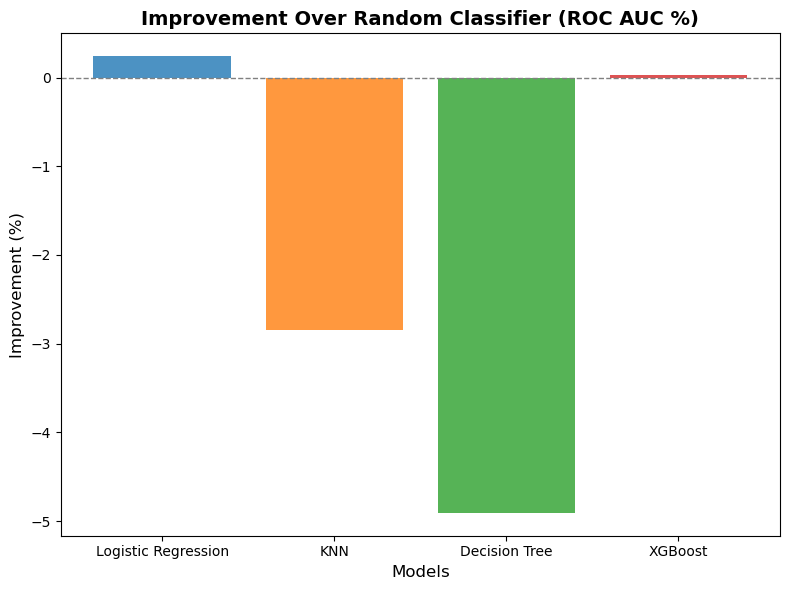

In [ ]:
import matplotlib.pyplot as plt

# Extract improvement over random classifier
improvements = {
    model: (comparison_data[model]['ROC AUC'] - comparison_data['Random']['ROC AUC']) * 100
    for model in ['Logistic Regression', 'KNN', 'Decision Tree', 'XGBoost']
}

# Define custom colors for each bar
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(improvements.keys(), improvements.values(), color=custom_colors, alpha=0.8)
plt.title("Improvement Over Random Classifier (ROC AUC %)", fontsize=14, weight='bold')
plt.xlabel("Models", fontsize=12)
plt.ylabel("Improvement (%)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Add a horizontal line at 0
plt.tight_layout()
plt.show()

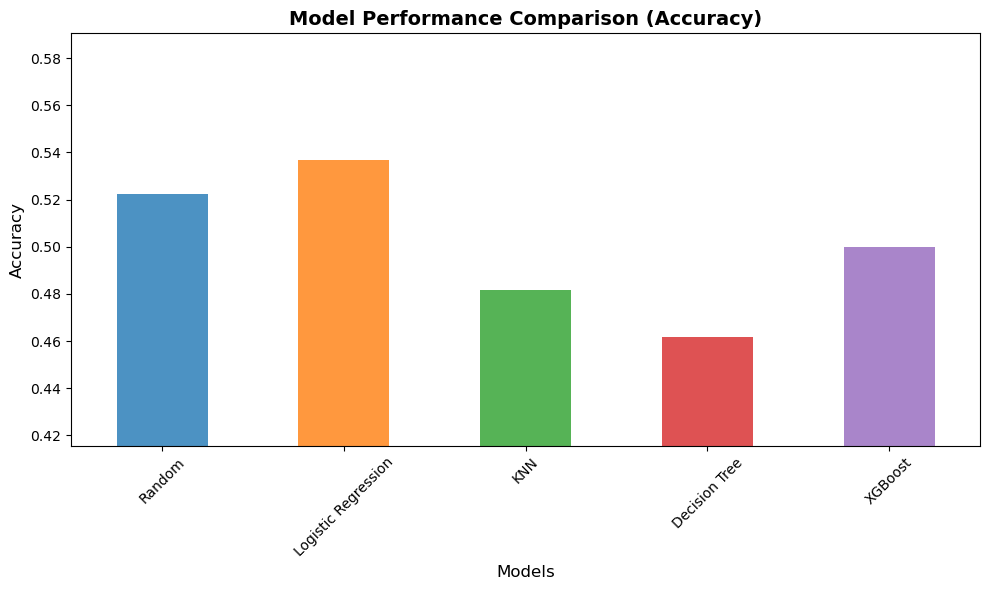

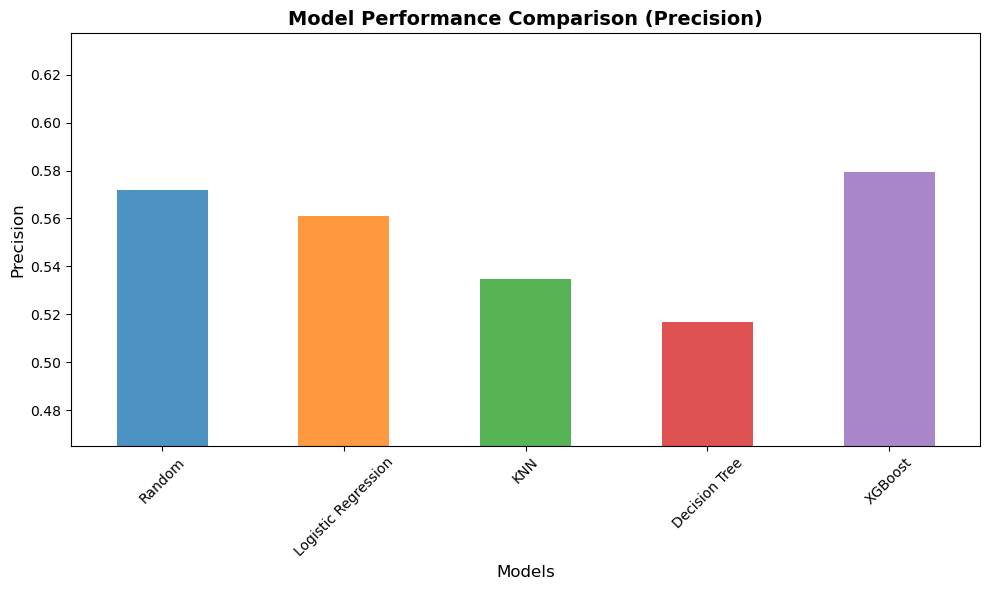

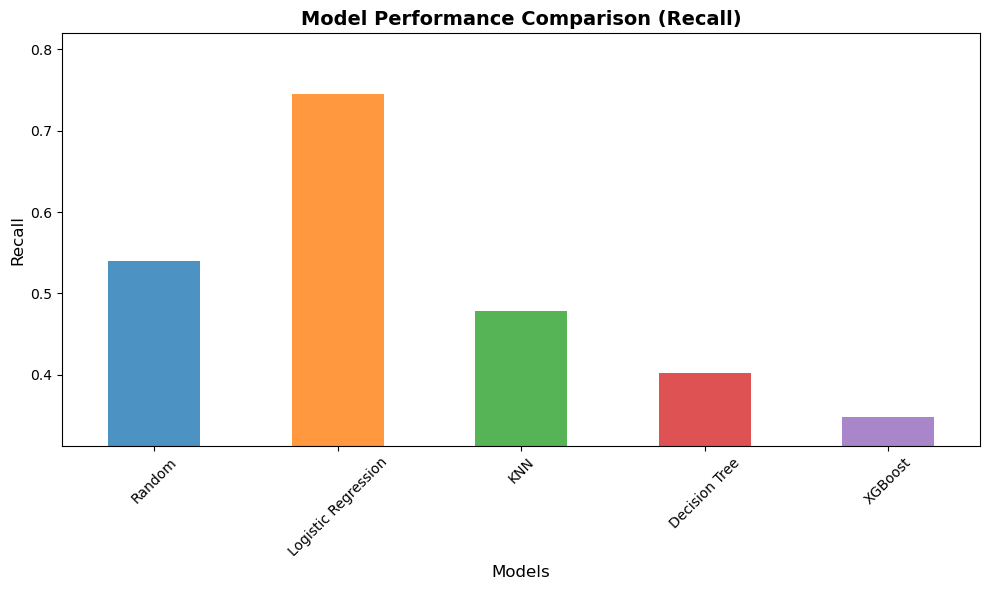

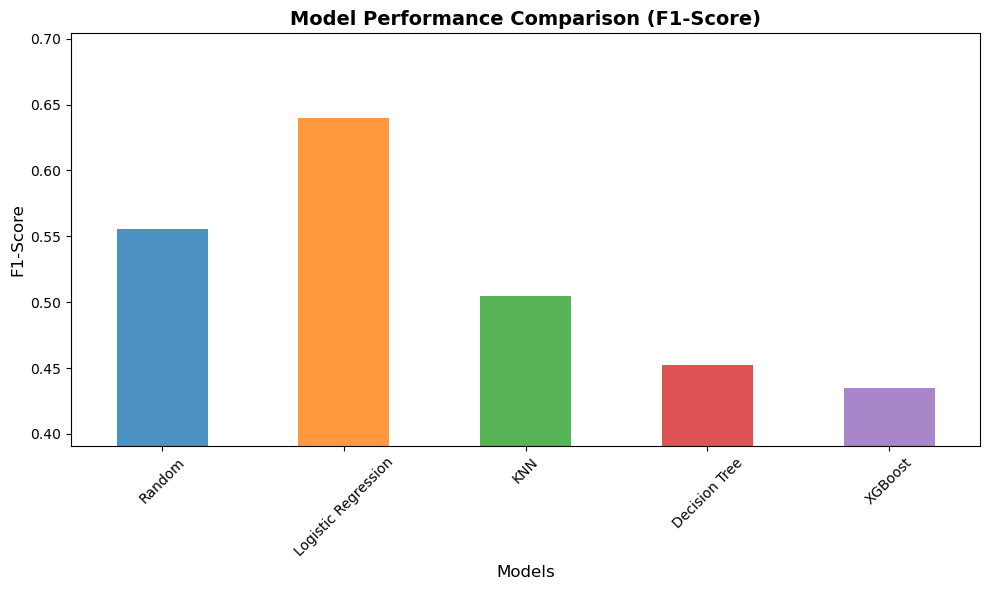

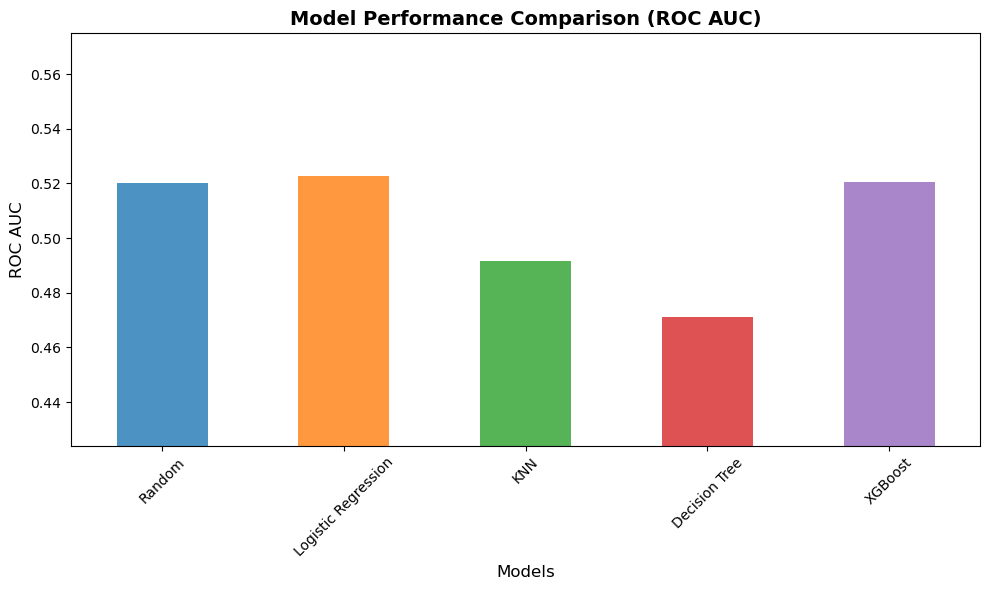

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert comparison data to DataFrame
comparison_df = pd.DataFrame(comparison_data).T

# Select metrics to plot
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']

# Create a bar chart for each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    comparison_df[metric].plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], alpha=0.8)
    plt.title(f"Model Performance Comparison ({metric})", fontsize=14, weight='bold')
    plt.ylabel(metric, fontsize=12)
    plt.xlabel("Models", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    
    # Dynamically adjust the y-axis scale
    metric_min = comparison_df[metric].min() * 0.9  # Add some padding below
    metric_max = comparison_df[metric].max() * 1.1  # Add some padding above
    plt.ylim(metric_min, metric_max)
    
    plt.tight_layout()
    plt.show()